In [39]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline


In [61]:
#importing training data
traindat = pd.read_csv("/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")
#importing test data
testdat = pd.read_csv("/Users/ellisobrien/Desktop/Georgetown Semester 1/Data Science/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")


In [62]:
# Drop all observations where the outcome is missing 
traindat = traindat[~traindat.LN_PRICE.isna()]
# Only houses that are sold
traindat = traindat[traindat.LN_PRICE > 0]
# Drop all observations where the outcome is missing 
testdat = testdat[~testdat.LN_PRICE.isna()]
# Only houses that are sold
testdat = testdat[testdat.LN_PRICE > 0]


In [52]:
#selecting columns for the price predictions (training data)
traindat = traindat[['BATHRM', 'STORIES', 'ROOMS', 'BEDRM', 'LANDAREA', 'LN_PRICE']]
#selecting columns for the price predictions (testing data)
testdat = testdat[['BATHRM', 'STORIES', 'ROOMS', 'BEDRM', 'LANDAREA', 'LN_PRICE']]



In [63]:
#traindinng data
train_x = traindat[['BATHRM', 'STORIES', 'ROOMS', 'BEDRM', 'LANDAREA']]
train_y = traindat[['LN_PRICE']]

#selecting columns for the price predictions (testing data)
test_x = testdat[['BATHRM', 'STORIES', 'ROOMS', 'BEDRM', 'LANDAREA']]
test_y = testdat[['LN_PRICE']]




In [64]:
# fill na with 0 where the input is missing 
train_x['BATHRM'] = train_x['BATHRM'].fillna(0)
train_x['STORIES'] = train_x['STORIES'].fillna(0)
train_x['ROOMS'] = train_x['ROOMS'].fillna(0)
train_x['BEDRM'] = train_x['BEDRM'].fillna(0)
train_x['LANDAREA'] = train_x['LANDAREA'].fillna(0)


# fill na with 0 for observations where the outcome is missing 
test_x['BATHRM'] = test_x['BATHRM'].fillna(0)
test_x['STORIES'] = test_x['STORIES'].fillna(0)
test_x['ROOMS'] = test_x['ROOMS'].fillna(0)
test_x['BEDRM'] = test_x['BEDRM'].fillna(0)
test_x['LANDAREA'] = test_x['LANDAREA'].fillna(0)

In [73]:
#creating sample to plot distributions 
# Subsample
train_x_subset = train_x.sample(1000,random_state=1234)
train_y_subset = train_y.sample(1000,random_state=1234)

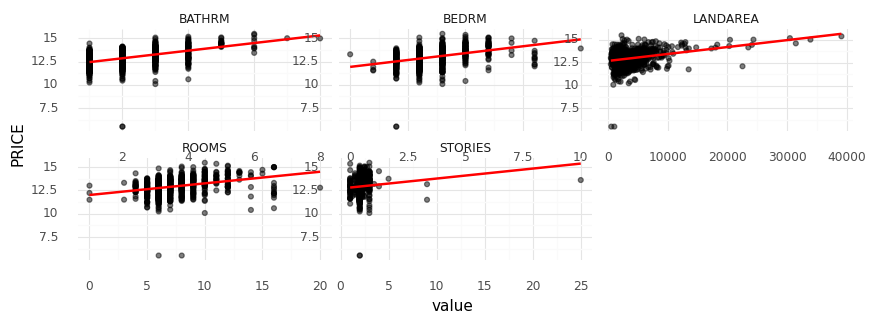

<ggplot: (8763387565855)>

In [74]:
D = train_x_subset.copy()
D['PRICE'] = train_y_subset

(
    ggplot(D.melt(id_vars=["PRICE"]),
           aes(x="value",y="PRICE"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

In [65]:

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM', 'STORIES', 'ROOMS', 'BEDRM', 'LANDAREA'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'STORIES',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=30)],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},

In [66]:
print(search.best_score_) 
print(search.best_params_)

-0.5076403930615936
{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}


In [69]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_x)
print(m.mean_squared_error(test_y,pred_y))
print(m.r2_score(test_y,pred_y))

0.5104118782313877
0.30977564375415567


#### Observations
The KNN model provided the best predictor of home price given the input variables I decided to use. This model provides a mean squared error of  0.5104118782313877 and an R^2 of 0.30977564375415567.
